In [2]:
#pip install tifffile

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import rasterio as rio
from rasterio.plot import reshape_as_image, reshape_as_raster
from pathlib import Path
from osgeo import ogr, gdal
import matplotlib.pyplot as plt
import tifffile as tiff

In [52]:
def apply_mask(image):
    mask_norm = np.all((image >= 0) & (image <= 1), axis=2)
    mask_zero = np.all(image == 0, axis=2)
    image[(~mask_norm) | (mask_zero)] = np.nan
    image = reshape_as_raster(image)
    return image

print("test")
image_path = r'C:\Users\arman\Desktop\INSA Toulouse\5A\PIR\PIR-Rio-Tinto\INSA_Crop_EnMAP.tif'

with rio.open(image_path) as src:
    cube = src.read()  # shape = (BANDS, H, W)

l, m, n = cube.shape # check the size of the image 

print(cube.shape)
# 1️⃣ On met en forme : chaque pixel devient une ligne
X = cube.reshape(l, -1).T
print("Size of the image is "+str(l)+"x"+str(m)+"x"+str(n))

# 2️⃣ Centrage et réduction sur les bandes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ Conversion en tenseur PyTorch
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
print(X_scaled.shape)

# cube : shape = (H, W, BANDS)
cube_min = cube.min(axis=(1,2), keepdims=True)  # min par bande
cube_max = cube.max(axis=(1,2), keepdims=True)  # max par bande

cube_norm = (cube - cube_min) / (cube_max - cube_min + 1e-8)  # ajouter epsilon pour éviter division par 0

cube_norm =  torch.tensor(cube_norm, dtype=torch.float32)

print(cube_norm.shape)

test
(224, 304, 393)
Size of the image is 224x304x393
(119472, 224)
torch.Size([224, 304, 393])


(224, 304, 393)


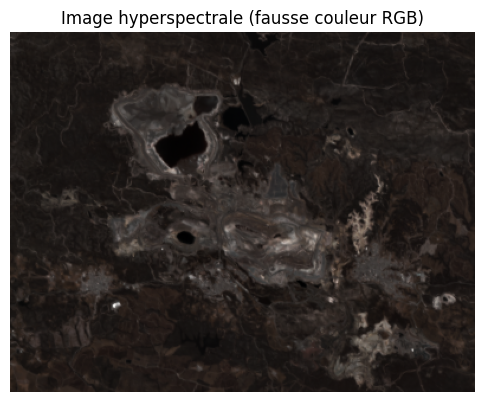

In [49]:
import numpy as np
import rasterio

with rasterio.open(image_path) as src:
    cube = src.read()  # shape = (BANDS, H, W)
    print(cube.shape)
    cube = np.transpose(cube, (1, 2, 0))  # → (H, W, BANDS)

# Choisir 3 bandes pour RGB
r_band = 20   # index de la bande rouge
g_band = 10   # index de la bande verte
b_band = 5    # index de la bande bleue

rgb_image = np.stack([
    cube_norm[r_band, :, :],
    cube_norm[g_band, :, :],
    cube_norm[b_band, :, :]
], axis=2)  # shape = (H, W, 3)
# Créer une image RGB

# Afficher
plt.figure(figsize=(6,6))
plt.imshow(rgb_image)
plt.title("Image hyperspectrale (fausse couleur RGB)")
plt.axis('off')
plt.show()


In [5]:
# On essaie d'abord sans ACP
"""
# 3️⃣ PCA (par exemple 95 % de variance expliquée)
pca = PCA(n_components=0.999)
X_pca = pca.fit_transform(X_scaled)

# 4️⃣ On peut reformer l'image PCA (même taille spatiale)
nb_comp = X_pca.shape[1]
print(X_pca.shape)
image_pca = X_pca.reshape(m, n, nb_comp)

print(image_pca.shape)
print("Variance expliquée : ", np.sum(pca.explained_variance_ratio_))
print(nb_comp)
"""
X_entry = X_tensor.reshape(n, m, l)

In [ ]:
"""

import torch.nn.functional as F

def make_square(image_tensor):
    # image_tensor: (C, H, W)
    C, H, W = image_tensor.shape
    size = max(H, W)
    # padding : (left, right, top, bottom)
    pad_left = (size - W) // 2
    pad_right = size - W - pad_left
    pad_top = (size - H) // 2
    pad_bottom = size - H - pad_top
    image_tensor = F.pad(image_tensor, (pad_left, pad_right, pad_top, pad_bottom))
    return image_tensor

# image: (C, H, W)
image_square = make_square(X_entry.T)
print(image_square.shape)
"""

torch.Size([224, 393, 393])


C:\Users\arman\AppData\Local\Temp\ipykernel_18664\1090700097.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4424.)
  image_square = make_square(X_entry.T)


In [13]:
class SpectralConvAE(nn.Module):
    def __init__(self, bands, latent_dim):
        super().__init__()

        # Encodeur 1D
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * bands, latent_dim)
        )
        
        # Décodeur
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 32 * bands),
            nn.ReLU()
        )
        self.decoder_conv = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 1, kernel_size=5, padding=2),
            nn.Sigmoid()
        )

        self.bands = bands

    def forward(self, x):
        # x : (batch, bands)
        x = x.unsqueeze(1)                  # → (batch, 1, bands)
        z = self.encoder(x)
        x = self.decoder_fc(z)
        x = x.view(-1, 32, self.bands)
        x = self.decoder_conv(x)
        return x.squeeze(1), z

In [29]:
class LinearAutoencoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()

        # ----- Encodeur -----
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # ----- Décodeur -----
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, in_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_rec = self.decoder(z)
        return x_rec, z

In [14]:
def train_autoencoder(model, dataloader, epochs, criterion, optimizer, device):
    model.train()
    for ep in range(epochs):
        loss_sum = 0
        for x, in dataloader:
            x = x.to(device)

            out, _ = model(x)
            loss = criterion(out, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss.item()

        print(f"Epoch {ep+1}/{epochs}   Loss = {loss_sum/len(dataloader):.6f}")

In [15]:
def encode_all(model, dataloader, device):
    model.eval()
    latents = []

    with torch.no_grad():
        for x, in dataloader:
            x = x.to(device)
            _, z = model(x)
            latents.append(z.cpu().numpy())

    return np.concatenate(latents, axis=0)

In [27]:
import matplotlib.colors as mcolors

def get_n_colors(n):
    base = plt.cm.get_cmap("tab20")   # ou "nipy_spectral", "viridis", etc.
    colors = base(np.linspace(0, 1, n))
    return mcolors.ListedColormap(colors)

torch.Size([224, 119472])
Epoch 1/1   Loss = 0.003894


C:\Users\arman\AppData\Local\Temp\ipykernel_18664\3351488288.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = plt.cm.get_cmap("tab20")   # ou "nipy_spectral", "viridis", etc.


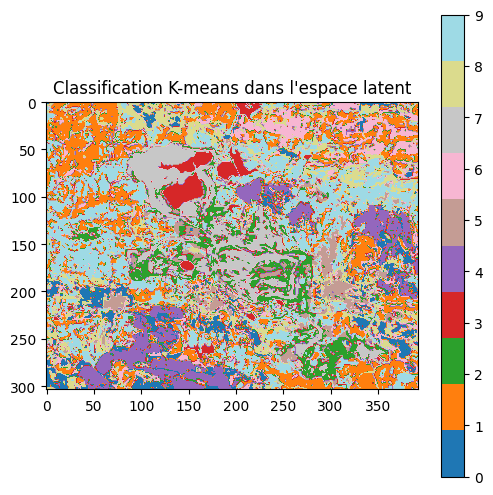

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

print(cube_norm.reshape(l, -1).shape)
if __name__ == "__main__":

    # ------------------------------------------------------------------
    # Données simulées (remplace par tes vraies données)
    # ------------------------------------------------------------------
    H, W = m, n             # taille image
    BANDS = l                    # nb de bandes spectrales
    LATENT_DIM = 64               # taille espace latent
    EPOCHS = 1
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = TensorDataset(cube_norm.reshape(l, -1).T)
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
    loader_ordered = DataLoader(dataset, batch_size=256, shuffle=False)

    # ------------------------------------------------------------------
    # Autoencodeur
    # ------------------------------------------------------------------
    model = LinearAutoencoder(BANDS, LATENT_DIM).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Entraînement
    train_autoencoder(model, loader, EPOCHS, criterion, optimizer, DEVICE)

    # ------------------------------------------------------------------
    # Extraction du latent
    # ------------------------------------------------------------------
    latent_vectors = encode_all(model, loader_ordered, DEVICE)   # shape = (H*W, LATENT_DIM)

    # ------------------------------------------------------------------
    # K-means
    # ------------------------------------------------------------------
    n_clusters = 10
    kmeans = KMeans(n_clusters, n_init=5, random_state=0)
    labels_1d = kmeans.fit_predict(latent_vectors)

    classification_map = labels_1d.reshape(H, W)

    # ------------------------------------------------------------------
    # Affichage
    # ------------------------------------------------------------------
    cmapK = get_n_colors(n_clusters)

    plt.figure(figsize=(6, 6))
    plt.imshow(classification_map, cmap=cmapK)
    plt.title("Classification K-means dans l'espace latent")
    plt.colorbar()
    plt.show()